In [9]:
# load train.csv and test.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Check for missing data

In [10]:
print(df.isna().sum())

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


In [11]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


Check class imbalance

In [12]:
df['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

Upsample minority class

In [13]:
import pandas as pd
from sklearn.utils import resample

# Assuming your dataframe is called 'df' and the target column is 'loan_status'

# Separate majority and minority classes
df_majority = df[df.loan_status==0]
df_minority = df[df.loan_status==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check new class counts
print(df_upsampled.loan_status.value_counts())

loan_status
0    50295
1    50295
Name: count, dtype: int64


Categorical encoding

In [14]:
X = df_upsampled.drop(['loan_status', 'id'], axis=1)
y = df_upsampled['loan_status']

print(X.shape)
print(y.shape)

(100590, 11)
(100590,)


In [17]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3


Encode ordinal features

In [18]:
X['loan_grade'].value_counts()

loan_grade
B    31179
A    26091
D    19893
C    18552
E     4099
F      613
G      163
Name: count, dtype: int64

In [19]:
loan_grade_dict = { 'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0 }
X['loan_grade'] = X['loan_grade'].map(loan_grade_dict)
X['loan_grade'].value_counts()

loan_grade
5    31179
6    26091
3    19893
4    18552
2     4099
1      613
0      163
Name: count, dtype: int64

In [21]:
X = pd.get_dummies(X, drop_first=True)

In [22]:
X.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,37,35000,0.0,5,6000,11.49,0.17,14,False,False,True,True,False,False,False,False,False
1,22,56000,6.0,4,4000,13.35,0.07,2,False,True,False,False,False,True,False,False,False
2,29,28800,8.0,6,6000,8.90,0.21,10,False,True,False,False,False,False,True,False,False
3,30,70000,14.0,5,12000,11.11,0.17,5,False,False,True,False,False,False,False,True,False
4,22,60000,2.0,6,6000,6.92,0.10,3,False,False,True,False,False,True,False,False,False


Feature scaling

In [24]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to X and transform X
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame to keep column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Train 

In [26]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Fit the model
xgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9357


In [30]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Assuming X_scaled and y are already defined

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }
    
    model = xgb.XGBClassifier(**params, random_state=42)
    
    # Perform cross-validation
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Return the mean accuracy
    return score.mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 50

# Run the optimization
with tqdm(total=n_trials, desc="Optuna Trials") as pbar:
    for i in range(n_trials):
        study.optimize(objective, n_trials=1)
        pbar.update(1)
        pbar.set_postfix({"Best Accuracy": study.best_value})


# Print the best parameters and the best score
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Train the model with the best parameters
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

[I 2024-10-29 15:32:36,124] A new study created in memory with name: no-name-6497c9bf-6e87-48df-af1f-d7cd732f7d09
Optuna Trials: 100%|██████████| 50/50 [12:45<00:00, 15.31s/it, Best Accuracy=0.98]


Best trial:
  Value:  0.980142148722172
  Params: 
    max_depth: 9
    learning_rate: 0.16055491361099353
    n_estimators: 727
    min_child_weight: 1
    subsample: 0.6220590049853978
    colsample_bytree: 0.5826010624270892
    gamma: 0.0008664251103306306
    reg_alpha: 0.6683824456413817
    reg_lambda: 0.9872266161591827

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     10082
           1       0.97      1.00      0.98     10036

    accuracy                           0.98     20118
   macro avg       0.98      0.98      0.98     20118
weighted avg       0.98      0.98      0.98     20118


Accuracy: 0.9829


In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Load the test data
test = pd.read_csv("data/test.csv")

# Step 1: Preprocess the test data
# Drop 'id' column (assuming you want to keep it for submission, we'll save it separately)
test_id = test['id']
X_test = test.drop('id', axis=1)

X_test.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [37]:

# Ensure X_test has the same columns as X_train
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

# Step 2: Handle categorical variables
X_test['loan_grade'] = X_test['loan_grade'].map(loan_grade_dict)
X_test = pd.get_dummies(X_test, drop_first=True)

# Step 3: Scale the features
X_test_scaled = scaler.transform(X_test)

# Step 4: Make predictions using the best model
y_pred = best_model.predict(X_test_scaled)

# Step 5: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_id,
    'loan_status': y_pred
})

# Step 6: Save the predictions to a CSV file
submission.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")

Predictions saved to submission.csv


# Model 2: do not upsample

In [58]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [106]:
from imblearn.over_sampling import SMOTE

def preprocess(data, scaler=None):
    X = data.drop('id', axis=1)
    
    
    # if X has loan_status column
    if 'loan_status' in X.columns:
        y = X['loan_status']
        X = X.drop('loan_status', axis=1)
    else:
        y = None
        
    loan_grade_dict = {
        'A': 6,
        'B': 5,
        'C': 4,
        'D': 3,
        'E': 2,
        'F': 1,
        'G': 0
    }
    
    X['loan_grade'] = X['loan_grade'].map(loan_grade_dict)
    X = pd.get_dummies(X, drop_first=True)
    
    # scale
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(X)
    
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    if y is not None:
        smote = SMOTE()
        X_scaled, y = smote.fit_resample(X_scaled, y)
    
    return X_scaled, y, scaler

In [107]:
df = pd.read_csv("data/train.csv")
X, y, scaler = preprocess(df)

In [108]:
X.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
0,1.566200,-0.765768,-1.187200,0.063697,-0.578306,0.267616,0.117378,2.031798,-0.038986,-0.237768,0.957538,1.944005,-0.346305,-0.478719,-0.453837,-0.4537,-0.417419
1,-0.920057,-0.212128,0.328047,-0.892168,-0.937775,0.880532,-0.973242,-0.946489,-0.038986,4.205788,-1.044345,-0.514402,-0.346305,2.088910,-0.453837,-0.4537,-0.417419
2,0.240196,-0.929223,0.833130,1.019563,-0.578306,-0.585854,0.553626,1.039036,-0.038986,4.205788,-1.044345,-0.514402,-0.346305,-0.478719,2.203436,-0.4537,-0.417419
3,0.405947,0.156966,2.348377,0.063697,0.500101,0.142396,0.117378,-0.201917,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,-0.478719,-0.453837,2.2041,-0.417419
4,-0.920057,-0.106673,-0.682117,1.019563,-0.578306,-1.238314,-0.646056,-0.698298,-0.038986,-0.237768,0.957538,-0.514402,-0.346305,2.088910,-0.453837,-0.4537,-0.417419


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Create XGBoost classifier with the specified parameters
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

train_acc = accuracy_score(y_train, xgb_model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9758
Test accuracy: 0.9700


In [111]:
def submit():
    test_df = pd.read_csv("data/test.csv")
    X_test, _, _ = preprocess(test_df, scaler)
    y_pred = xgb_model.predict(X_test)
    submission = pd.DataFrame({
        'id': test_df['id'],
        'loan_status': y_pred
    })
    submission.to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    return submission

In [97]:
submit()

Predictions saved to submission.csv


,id,loan_status
0,58645,1
1,58646,0
2,58647,0
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,0


In [112]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
cv_scores = []
for train_idx, val_idx in kf.split(X):
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model.predict(X.iloc[val_idx])
    train_acc = accuracy_score(y.iloc[train_idx], model.predict(X.iloc[train_idx]))
    test_acc = accuracy_score(y.iloc[val_idx], y_pred)
    
    print (f'{train_acc:.4f}', f'{test_acc:.4f}')

0.9752 0.9673
0.9753 0.9685
0.9760 0.9673
0.9762 0.9671
0.9760 0.9687


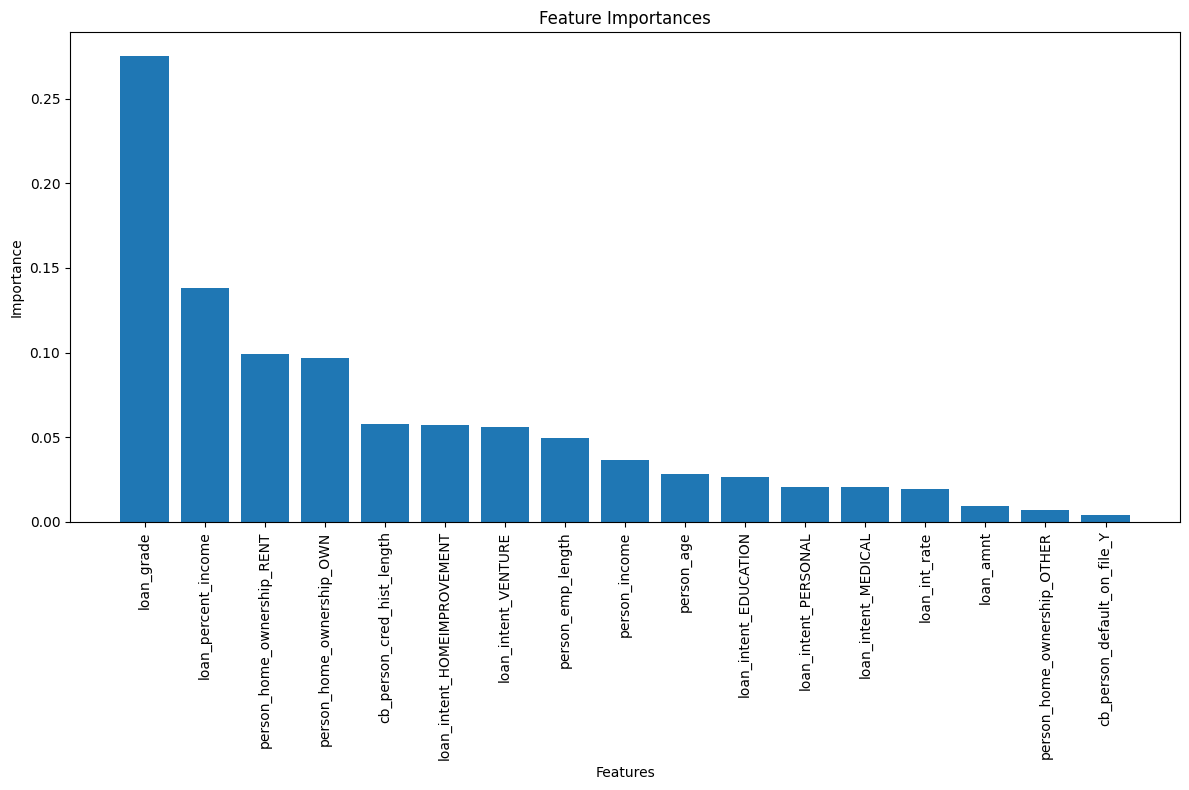

Top 10 most important features:
1. loan_grade (0.275596)
2. loan_percent_income (0.137890)
3. person_home_ownership_RENT (0.098908)
4. person_home_ownership_OWN (0.096636)
5. cb_person_cred_hist_length (0.057793)
6. loan_intent_HOMEIMPROVEMENT (0.057195)
7. loan_intent_VENTURE (0.056034)
8. person_emp_length (0.049311)
9. person_income (0.036466)
10. person_age (0.028373)


In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 most important features:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))